#Data Processing
Let's explore our datasets to look for probability distributions on the features and correlations between features and labels, and preprocess the data according to our findings.  


In [ ]:
#importing dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mpl_toolkits.mplot3d import axes3d

#Mouting a connection to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Change your path if you need too
path_Theo = '/content/drive/My Drive/COMP 551/Assignments/Assignment 1/'
path_David = ''
path_Jacob = '' 

path = path_Theo

Mounted at /content/drive


##1 Hepatitis Dataset

A quick look at the hepatitis dataset shows us that the features are not normalized, and that for some data samples, we have missing features. 

In [ ]:
#reference dataset without removal of data
ref_hep = pd.read_csv(path+'hepatitis.csv') 
ref_hep.head()

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,2,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,2,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,2,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,2,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,2,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1


Looks like we have two classes. To standardize our functions for other datasets, let's label the classes as 1 and 0. 

In [ ]:
ref_hep.loc[ref_hep['Class'] == 1, 'Class'] = 0
ref_hep.loc[ref_hep['Class'] == 2, 'Class'] = 1
ref_hep.head()

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,1,30,2,1,2,2,2,2,1,2,2,2,2,2,1.00,85,18,4.0,?,1
1,1,50,1,1,2,1,2,2,1,2,2,2,2,2,0.90,135,42,3.5,?,1
2,1,78,1,2,2,1,2,2,2,2,2,2,2,2,0.70,96,32,4.0,?,1
3,1,31,1,?,1,2,2,2,2,2,2,2,2,2,0.70,46,52,4.0,80,1
4,1,34,1,2,2,2,2,2,2,2,2,2,2,2,1.00,?,200,4.0,?,1


### 1.1 Removing Examples with Missing Features

Let's have a quick look at how many examples have no data for a given feature. 

In [ ]:
def show_missing(df): 
  '''show how many missing values in each column of the dataframe
  '''
  for column in df:
    null_count = len(df[df[column].eq('?')])
    print(f'{null_count} missing values in {column}')

print(f'Missing data in Hepatitis dataset')
print(f'{len(ref_hep.columns)} features in hepatitis dataset')
print(f'{len(ref_hep)} total examples in hepatitis dataset\n')
show_missing(ref_hep)

Missing data in Hepatitis dataset
20 features in hepatitis dataset
155 total examples in hepatitis dataset

0 missing values in Class
0 missing values in AGE
0 missing values in SEX
1 missing values in STEROID
0 missing values in ANTIVIRALS
1 missing values in FATIGUE
1 missing values in MALAISE
1 missing values in ANOREXIA
10 missing values in LIVER_BIG
11 missing values in LIVER_FIRM
5 missing values in SPLEEN_PALPABLE
5 missing values in SPIDERS
5 missing values in ASCITES
5 missing values in VARICES
6 missing values in BILIRUBIN
29 missing values in ALK_PHOSPHATE
4 missing values in SGOT
16 missing values in ALBUMIN
67 missing values in PROTIME
0 missing values in HISTOLOGY


Look's like we have we have missing features for many examples. We can drop examples that are missing features. However, some features have too much missing data. In the case of the PROTIME feature, 43% of the data is missing. 

Before we start removing examples and features, lets have a quick look at our distribution to determine if our datasets are skewed as we don't want to further skew the data too much. 

In [ ]:
hep_positive = ref_hep.loc[ref_hep['Class'] == 0]
hep_negative = ref_hep.loc[ref_hep['Class'] == 1]

print(f'There are {len(hep_positive)} instances of positive hepatitis')
print(f'There are {len(hep_negative)} instances of negative hepatitis')

There are 32 instances of positive hepatitis
There are 123 instances of negative hepatitis


Let's now see if removing examples with missing data impacts the skewness of our dataset. 

In [ ]:
def drop_missing(df, ratio=0.15):
  '''drop examples or features in the dataframe based on missing data
  @Param ratio : for a feature (column), minimum ratio of number of missing examples
                  to total examples, which determines if the entire feature will be dropped.  
  @Return df : dataset with removed missing features
  '''
  removed = []
  for column in df:
    null_count = len(df[df[column].eq('?')])
    if null_count / len(df) >= ratio:
      df = df.drop(column, axis=1)
      removed.append(column)
  delete = df[df.eq('?').any(1)]
  df = df.drop(delete.index, axis=0)
  return df, removed

hep_check = ref_hep.copy()
hep_check, removed = drop_missing(ref_hep, ratio=1.00)

print(f'Missing data in Hepatitis dataset')
print(f'{len(hep_check.columns)} features in hepatitis dataset')
print(f'{len(hep_check)} total examples in hepatitis dataset after removal')

Missing data in Hepatitis dataset
20 features in hepatitis dataset
80 total examples in hepatitis dataset after removal


Removing examples with missing features doesn't negatively impact the skewness of our dataset.

For computational purposes, let's also have a look at the datatypes in our dataset and convert them all to floating point numbers. 

In [ ]:
print(hep_check.dtypes)
hep_check = hep_check.apply(pd.to_numeric, errors='raise')

Class               int64
AGE                 int64
SEX                 int64
STEROID            object
ANTIVIRALS          int64
FATIGUE            object
MALAISE            object
ANOREXIA           object
LIVER_BIG          object
LIVER_FIRM         object
SPLEEN_PALPABLE    object
SPIDERS            object
ASCITES            object
VARICES            object
BILIRUBIN          object
ALK_PHOSPHATE      object
SGOT               object
ALBUMIN            object
PROTIME            object
HISTOLOGY           int64
dtype: object


We also considered removing features containing many missing examples, such as ’PRO-TIME’, to conserve more data. This could pose a problem if these features are highly correlated with the class label. We chose to rank the features by the absolute value of their Pearson correlation coefficients, calculated against the class label. The aim was to drop features with too much missing data if its Pearson’s coefficient was low enough. We chose this measure of correlation has it measures covariance, and is normalized. As the direction of the correlation is irrelevant, the absolute value was taken.

In [ ]:
def rank_features(df):
  '''
  Ranking  features by correlation with the label. 
  Using an absolute value of the Pearson coefficient. 
  '''
  X = df.loc[:, df.columns != 'Class']
  y = df['Class']
  scores = {'Feature':[], 'Score':[]}
  for column in X: 
    scores['Feature'].append(column)
    scores['Score'].append(abs(y.corr(X[column], method='pearson')))
  scores = pd.DataFrame.from_dict(scores)
  scores = scores.sort_values('Score', ascending = False)
  return scores

rank_features(hep_check)


,Feature,Score
11,ASCITES,0.479211
16,ALBUMIN,0.477404
18,HISTOLOGY,0.456856
17,PROTIME,0.395386
13,BILIRUBIN,0.351557
12,VARICES,0.345785
10,SPIDERS,0.287839
5,MALAISE,0.275595
0,AGE,0.212769
7,LIVER_BIG,0.194030


The features ”PROTIME” and ”ALK PHOSPHATE”, which contained much missing data were moderately correlated to the label, as shown in table 2. Our conclusion was to create two datasets: one with these features removed, but more examples, and one with these features present, but fewer examples. The performance of our predictive models are tested for both these cases.

In [ ]:
hep_large, removed = drop_missing(ref_hep, ratio=0.15)
hep_large = hep_large.apply(pd.to_numeric, errors='raise')
print(f'Larger Hepatitis dataset')
print(f'{len(hep_large.columns)} features in larger dataset')
print(f'{len(hep_large)} total examples in larger dataset after removal')
print(f'Removed features: {removed}')

hep_small = hep_check
print(f'\nSmaller Hepatitis dataset')
print(f'{len(hep_small.columns)} features in smaller dataset')
print(f'{len(hep_small)} total examples in smaller dataset after removal')


Larger Hepatitis dataset
18 features in larger dataset
129 total examples in larger dataset after removal
Removed features: ['ALK_PHOSPHATE', 'PROTIME']

Smaller Hepatitis dataset
20 features in smaller dataset
80 total examples in smaller dataset after removal


###1.2 Histograms
To visualize the data distributions and the correlations to the label, we plotted histograms of positive and negative labels for each feature.

We'll use the dataset with more examples for creating most histograms. In the case of PROTIME and ALK_PHOSPHATE, we'll use the smaller dataset.  

The histograms below provide insight on the distribution of the data. Some features such as 'Histology' and 'Varices' are binary features. Other's such as 'Age' and 'Protime' are on a larger range. 
Moreover, these plots confirm the conclusions we drew from ranking the features by their Pearson correlation coefficient. 



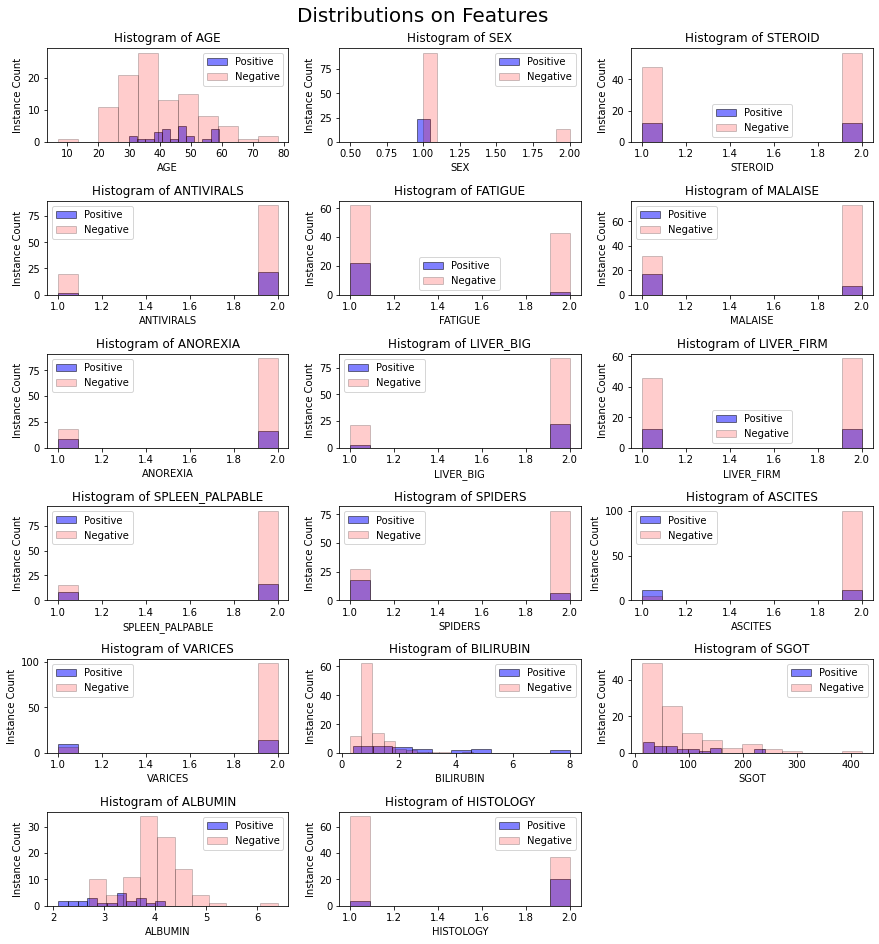

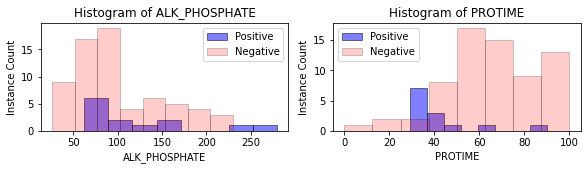

In [ ]:
def show_distributions(df, title):
  fig = plt.figure(figsize= (16,20))
  bin_num = int(len(df)**0.5) 
  if title: 
    plt.suptitle('Distributions on Features',fontsize=20, x =0.4)

  positives = df.loc[df['Class'] == 0]
  negatives = df.loc[df['Class'] == 1]
  i = 0
  for column in df: 
    i += 1
    if column == 'Class': i -= 1
    else:
      fig.add_subplot(9,3,i)
      plt.hist(positives[column], bins = bin_num, alpha=0.5, label='Positive', color = 'blue', edgecolor = 'black')
      plt.hist(negatives[column], bins = bin_num, alpha=0.2, label='Negative', color = 'red', edgecolor = 'black')
      plt.title(f'Histogram of {column}')
      plt.xlabel(column)
      plt.ylabel('Instance Count'), plt.legend()
  fig.tight_layout(rect=[0.03, 0.03, 0.8, 0.97])
  plt.show()


show_distributions(hep_large, title = True)
show_distributions(pd.concat([hep_small['Class'],
      hep_small['ALK_PHOSPHATE'],hep_small['PROTIME']],
      axis=1), title = False)

###1.3 Heat Map
The correlations were also represented using a heatmap. It shows that the three most strongly correlated features were ”ASCITES” and ”ALBUMIN”. 

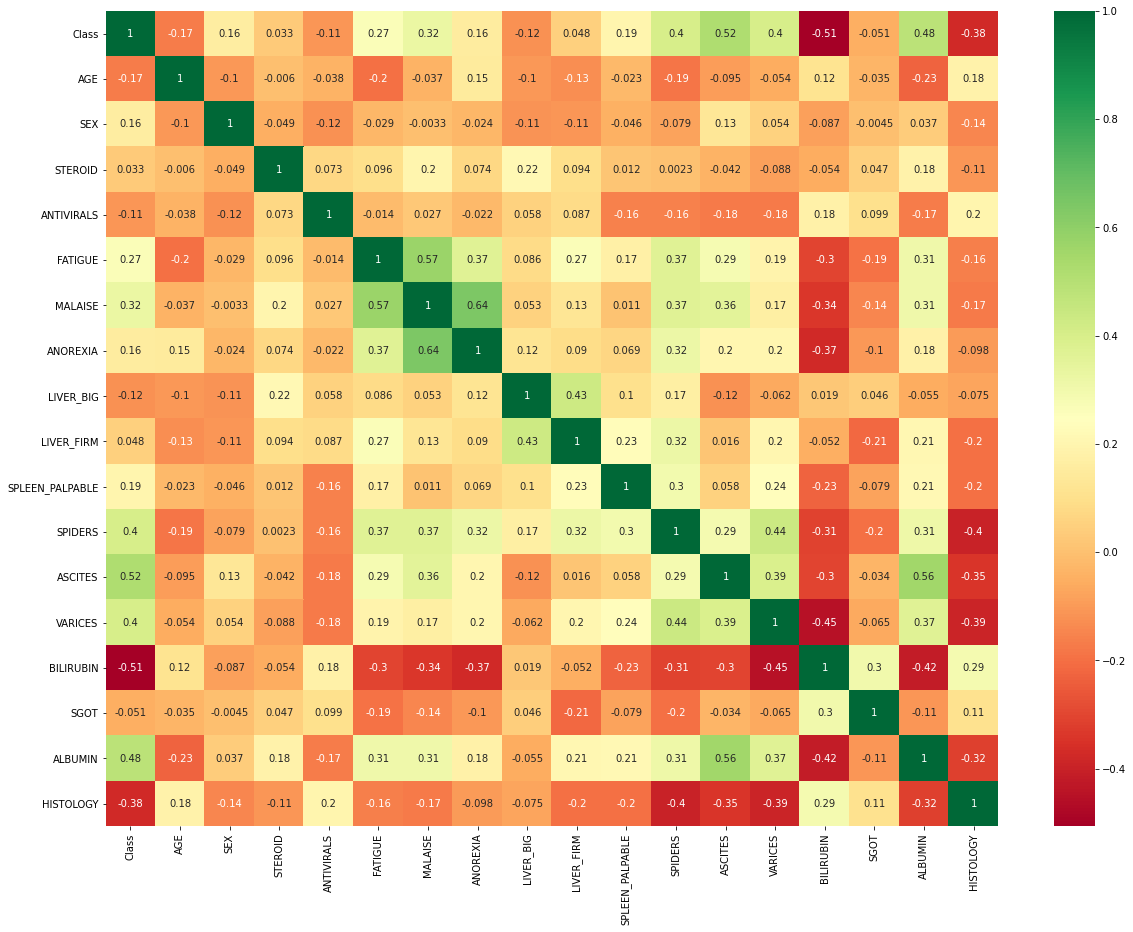

In [ ]:
def heat_map(df):
  '''visualize correlation matrix with a heat map'''
  X = df.iloc[:,1:]  #features
  y = df.iloc[:,:1]   #class 
  corrmat = df.corr()
  top_corr_features = corrmat.index
  plt.figure(figsize=(20,15))
  #plot heat map
  map = sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

heat_map(hep_large)


###1.3 Scatter Plot
The three most highly correlated features were plotted to assess their distributions graphically. As can be seen in figure 2, most positive cases of hepatitis have a histology scorer of 2, an ’Albumin’ score lower than 4, and an ’Ascites’ score of 1.

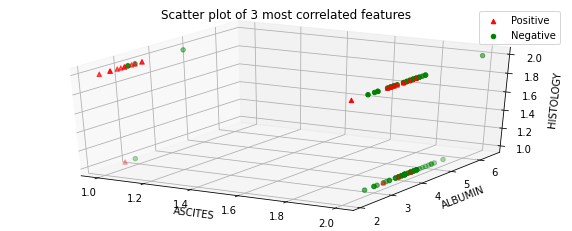

In [ ]:
# Creating dataset
pos_x = hep_large.loc[hep_large['Class'] == 0]['ASCITES'].to_numpy().astype(float)
pos_y = hep_large.loc[hep_large['Class'] == 0]['ALBUMIN'].to_numpy().astype(float)
pos_z = hep_large.loc[hep_large['Class'] == 0]['HISTOLOGY'].to_numpy().astype(float)
neg_x = hep_large.loc[hep_large['Class'] == 1]['ASCITES'].to_numpy().astype(float)
neg_y = hep_large.loc[hep_large['Class'] == 1]['ALBUMIN'].to_numpy().astype(float)
neg_z = hep_large.loc[hep_large['Class'] == 1]['HISTOLOGY'].to_numpy().astype(float)
 
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(projection='3d')
ax.scatter(pos_x, pos_y, pos_z, c='red', marker='^',label='Positive')
ax.scatter(neg_x, neg_y, neg_z, c='green', marker='o', label='Negative')
plt.title('Scatter plot of 3 most correlated features')
plt.legend(loc='upper right')
ax.set_xlabel('ASCITES')
ax.set_ylabel('ALBUMIN')
ax.set_zlabel('HISTOLOGY ')
plt.show()

###1.4 Normalization, Scaling and Feature Removal
After investigating the datasets, and after removing examples and features with missing data, we addressed the issues of normalization and scaling (the latter improving KNN per- formance).

The dataset was first normalised, and the features were scaled by a their Pearson’s cor- relation coefficient and a factor of 10. The most highly correlated features are scaled to a larger range, proportionally to their correlation. To assess the effect of scaling, we also have non-scaled, but normalized datasets.

Finally, we also created datasets in which we removed features with a Pearson’s corre- lation coefficient lower than 0.3. This retains only the features which are most predictive and lowers the dimension. This had the effect of lowering the feature space’s dimension of 20 to 7. Lowering the dimension has the effect on time of computation, and brings out the most meaningful and significant features of the dataset.


In [ ]:
def order_columns(df):
  rank = rank_features(df)
  column_rank = [x for _,x in sorted(zip(rank['Score'].tolist(),
                rank['Feature'].tolist()), reverse = True)]
  df = df[['Class']+column_rank]
  return df

#normalize dataset
def normalize(df):
  for column in df: 
    min, max = df[column].min(), df[column].max()
    df[column] = (df[column] - min) / (max - min)
  return df

#scale by correlation score and factor
def scale_features(df,scores,factor = 10):
  i = 0
  for column in df: 
    if column == 'Class': i-= 1
    else: 
      df[column] *= scores[i] * factor
  return df

def remove_features(df, scores, threshold = 0.3):
  to_drop = []
  i = 0
  for column in df: 
    if column != 'Class':
      if scores[i] < threshold:
        to_drop.append(column)
      i += 1
  df = df.drop(to_drop, axis=1)
  return df


hep_small_scaled = order_columns(hep_small)
hep_hep_small_scaled = normalize(hep_small_scaled)
hep_small_scaled = scale_features(hep_small_scaled,
                  rank_features(hep_check)['Score'].tolist())

hep_small_scaled_removed = remove_features(hep_small_scaled,
                  rank_features(hep_check)['Score'].tolist(), threshold = 0.3 )



hep_large_scaled = order_columns(hep_large)
hep_large_scaled = normalize(hep_large_scaled)
hep_large_scaled = scale_features(hep_large_scaled,
                  rank_features(hep_large_scaled)['Score'].tolist())

hep_large_scaled_removed = remove_features(hep_large_scaled,
                  rank_features(hep_check)['Score'].tolist(), threshold = 0.3 )


hep_small_unscaled = order_columns(hep_small)
hep_small_unscaled = normalize(hep_small_unscaled)
hep_small_unscaled_removed = remove_features(hep_small_unscaled,
                  rank_features(hep_check)['Score'].tolist(), threshold = 0.3 )


hep_large_unscaled = order_columns(hep_large)
hep_large_unscaled = normalize(hep_large_unscaled)
hep_large_unscaled_removed = remove_features(hep_large_unscaled,
                  rank_features(hep_check)['Score'].tolist(), threshold = 0.3 )


In [ ]:
hep_large_unscaled_removed.head()

,Class,ASCITES,BILIRUBIN,ALBUMIN,VARICES,SPIDERS,HISTOLOGY
0,1.0,1.0,0.090909,0.441860,1.0,1.0,0.0
1,1.0,1.0,0.077922,0.325581,1.0,1.0,0.0
2,1.0,1.0,0.051948,0.441860,1.0,1.0,0.0
4,1.0,1.0,0.090909,0.441860,1.0,1.0,0.0
5,1.0,1.0,0.077922,0.441860,1.0,1.0,0.0


We have 8 hepatitis datasets. 
1. hep_large_scaled: Normalized, then scaled data set with fewer features, but more data. 
2. hep_small_scaled: Normalized, then scaled data set with more features, but less data. 
3. hep_large_unscaled: Normalized, unscaled data set with fewer features, but more data.
4. hep_small_unscaled: Normalized, unscaled data set with more features, but less data.  
5. hep_large_scaled_removed: Normalized, then scaled data set with fewer features, but more data, removed features with a Pearson lower than 0.3
6. hep_small_scaled: Normalized, then scaled data set with more features, but less data, removed features with a Pearson lower than 0.3
7. hep_large_unscaled_removed: Normalized, unscaled data set with fewer features, but more data, removed features with a Pearson lower than 0.3
8. hep_small_unscaled_removed: Normalized, unscaled data set with more features, but less data,removed features with a Pearson lower than 0.3

In [ ]:
saving_path = path+'processed_data/'

hep_large_scaled.to_csv(saving_path + 'hep_large_scaled.csv')
hep_small_scaled.to_csv(saving_path + 'hep_small_scaled.csv')
hep_large_unscaled.to_csv(saving_path + 'hep_large_unscaled.csv')
hep_small_unscaled.to_csv(saving_path + 'hep_small_unscaled.csv')


hep_large_scaled_removed.to_csv(saving_path + 'hep_large_scaled_removed.csv')
hep_small_scaled_removed.to_csv(saving_path + 'hep_small_scaled_removed.csv')
hep_large_unscaled_removed.to_csv(saving_path + 'hep_large_unscaled_removed.csv')
hep_small_unscaled_removed.to_csv(saving_path + 'hep_small_unscaled_removed.csv')


print('_'*1000)


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

###1.5 Problems with Hepatitis Datasets
Numerous problems were identified in the Hepatitis dataset that may affect the perfor- mance of our learning algorithms.
1. There are only a maximum of 147 viable examples. This number is reduced to 100 when removing features ’Alk Phosphate’ and ’Protime’, which are moderately corre- lated to the class label.
2. The hepatitis dataset is skewed. The ratio of positive to negative examples is 18:129 in the larger dataset and 20:80 in the smaller dataset.
3. The most predictive features are only moderately correlated to the class label. In fact, the most highly correlated feature, ’Ascites’, has a Pearson coefficient of 0.479.
4. Some of the feature's ranges are binary, and some exist on a larger range. 


## 2 Breast Cancer Dataset
The cancer dataset was investigated through the same process as the hepatitis dataset. An intial look at the data shows two classes and that the data is not normalized. These incomplete examples were removed from the dataset. We also noted that one feature was labelled ’id’, which we supposed would not be correlated to the class label.


In [ ]:
#reference dataset without removal of data
ref_cancer = pd.read_csv(path+'breast_cancer_wisconsin.csv') 
ref_cancer.head()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Looks like we have two classes. Let's label the classes as 1 and 0 and move the Class column to the first index. 

In [ ]:
ref_cancer.loc[ref_cancer['Class'] == 2, 'Class'] = 0
ref_cancer.loc[ref_cancer['Class'] == 4, 'Class'] = 1
ref_cancer = ref_cancer[['Class'] + [col for col in ref_cancer.columns if col != 'Class']]
ref_cancer.head()

,Class,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,0,1000025,5,1,1,1,2,1,3,1,1
1,0,1002945,5,4,4,5,7,10,3,2,1
2,0,1015425,3,1,1,1,2,2,3,1,1
3,0,1016277,6,8,8,1,3,4,3,7,1
4,0,1017023,4,1,1,3,2,1,3,1,1


### 2.1 Removing Examples with Missing Features

Let's have a quick look at how many examples have no data for a given feature.

In [ ]:
print(f'Missing data in Breast Cancer dataset')
print(f'{len(ref_cancer.columns)} features in dataset')
print(f'{len(ref_cancer)} total examples in dataset')
show_missing(ref_cancer)

Missing data in Breast Cancer dataset
11 features in dataset
699 total examples in dataset
0 missing values in Class
0 missing values in id
0 missing values in Clump_Thickness
0 missing values in Uniformity_of_Cell_Size
0 missing values in Uniformity_of_Cell_Shape
0 missing values in Marginal_Adhesion
0 missing values in Single_Epithelial_Cell_Size
16 missing values in Bare_Nuclei
0 missing values in Bland_Chromatin
0 missing values in Normal_Nucleoli
0 missing values in Mitoses


Look's like our dataset is mostly complete. Since we have a lot of data, we can simply remove examples with missing date. 


In [ ]:
cancer,dropped = drop_missing(ref_cancer, ratio=1.00)

print(f'Missing data in Hepatitis dataset')
print(f'{len(cancer.columns)} features in  dataset')
print(f'{len(cancer)} total examples in dataset after removal')

Missing data in Hepatitis dataset
11 features in  dataset
683 total examples in dataset after removal


In [ ]:
cancer_negative = cancer.loc[cancer['Class'] == 0]
cancer_positive = cancer.loc[cancer['Class'] == 1]

print(f'There are {len(cancer_positive)} instances of positive breast cancer')
print(f'There are {len(cancer_negative)} instances of negative breast cancer')

There are 239 instances of positive breast cancer
There are 444 instances of negative breast cancer


For computational purposes, let's also have a look at the datatypes in our dataset and convert them all to floating point numbers. 

In [ ]:
print(cancer.dtypes)
cancer = cancer.apply(pd.to_numeric, errors='raise')

Class                          int64
id                             int64
Clump_Thickness                int64
Uniformity_of_Cell_Size        int64
Uniformity_of_Cell_Shape       int64
Marginal_Adhesion              int64
Single_Epithelial_Cell_Size    int64
Bare_Nuclei                    int64
Bland_Chromatin                int64
Normal_Nucleoli                int64
Mitoses                        int64
dtype: object


As with the hepatitis dataset, we ranked the features by their Pearson’s correlation coeffi- cient, as shown in table 4. The ’id’ feature’s score of 0.0847 confirmed our presuppositions, and the feature was removed. Conversely to the hepatitis dataset, many of the features in the cancer dataset are highly correlated to the class label. 

In [ ]:
print(rank_features(cancer))

                       Feature     Score
6                  Bare_Nuclei  0.822696
3     Uniformity_of_Cell_Shape  0.821891
2      Uniformity_of_Cell_Size  0.820801
7              Bland_Chromatin  0.758228
8              Normal_Nucleoli  0.718677
1              Clump_Thickness  0.714790
4            Marginal_Adhesion  0.706294
5  Single_Epithelial_Cell_Size  0.690958
9                      Mitoses  0.423448
0                           id  0.084701


In [ ]:
cancer = cancer.drop(labels='id', axis = 1)

###2.2 Histograms
To visualize the data distributions of the cancer dataset and the correlations of each feature to the label, we plotted histograms of positive and negative labels for each feature.

Generally, the feature values for negative breast cancer are concentrated in a small range, whereas those for negative breast cancer lie in over a larger range. This is expected as cancerous cells have more variance, as many factors such as disease progression can impact the value of these features. 

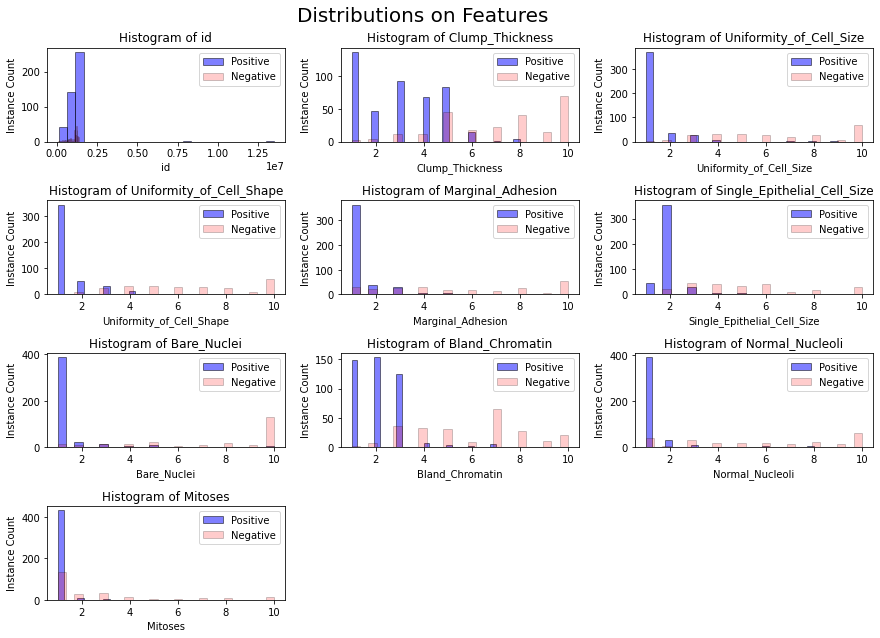

In [ ]:
show_distributions(cancer, title = True)

###2.3 Histograms
The correlations were also represented using a heatmap. It shows that the three most strongly correlated features were 'bare_nuclei', 'uniformity of cell shape' and 'uniformity of cell size'. 

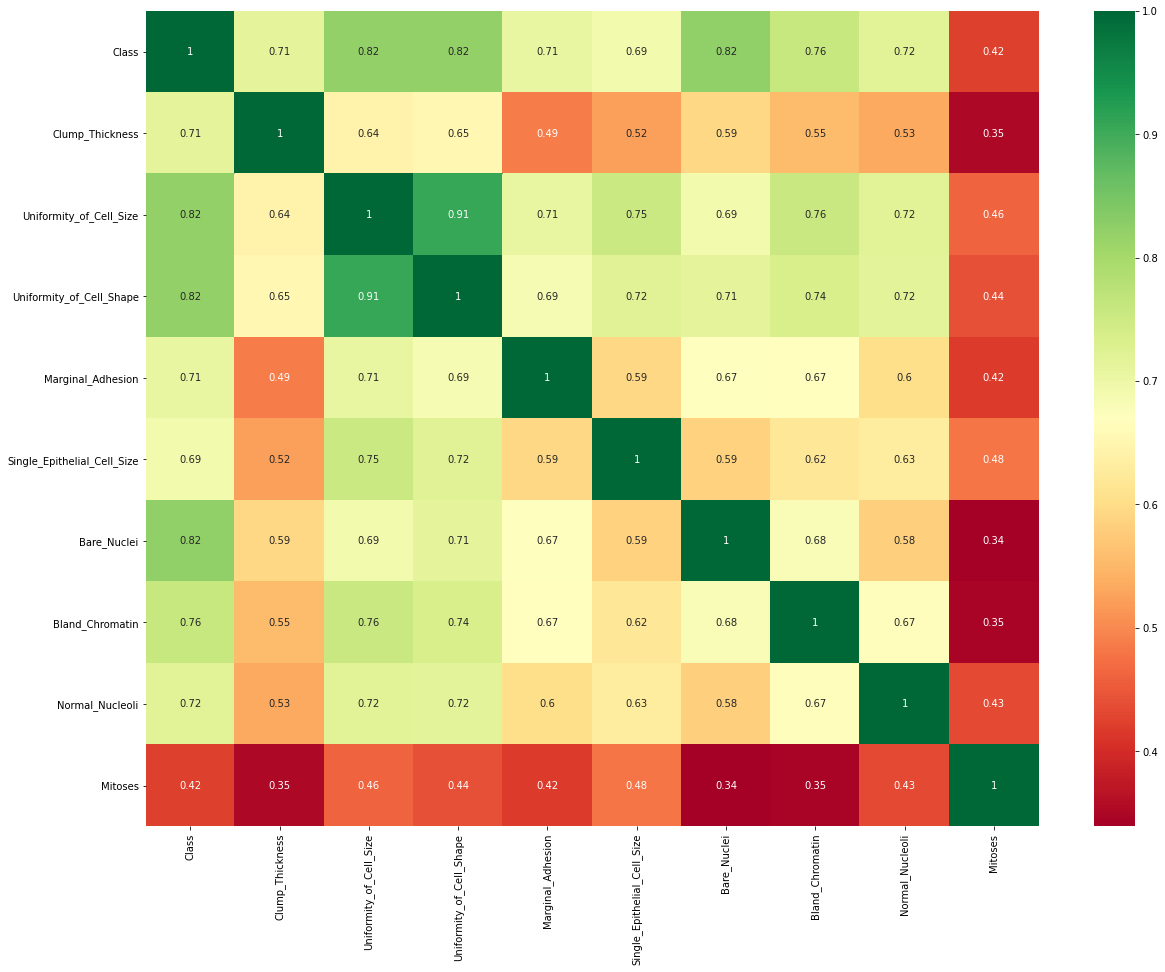

In [ ]:
heat_map(cancer)

###2.4 Scatter Plot
The three most highly correlated features were plotted to assess their distributions graphically. As can be seen in figure 4, positive cancer cases tended to have a ’bare nuclei’ between two and three, a ’uniformity of cell shape’ score between 2 and 4, and a ’uniformity of cell size’ score lower than 2. Furthermore, the data appears to be separable.

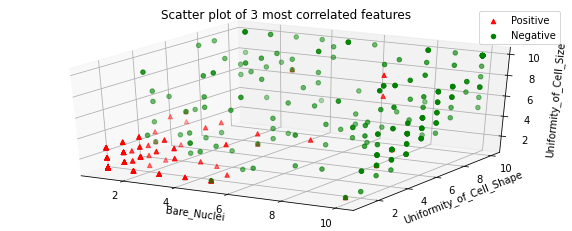

In [ ]:
pos_x = cancer.loc[cancer['Class'] == 0]['Bare_Nuclei'].to_numpy().astype(float)
pos_y = cancer.loc[cancer['Class'] == 0]['Uniformity_of_Cell_Shape'].to_numpy().astype(float)
pos_z = cancer.loc[cancer['Class'] == 0]['Uniformity_of_Cell_Size'].to_numpy().astype(float)
neg_x = cancer.loc[cancer['Class'] == 1]['Bare_Nuclei'].to_numpy().astype(float)
neg_y = cancer.loc[cancer['Class'] == 1]['Uniformity_of_Cell_Shape'].to_numpy().astype(float)
neg_z = cancer.loc[cancer['Class'] == 1]['Uniformity_of_Cell_Size'].to_numpy().astype(float)
 
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(projection='3d')
ax.scatter(pos_x, pos_y, pos_z, c='red', marker='^',label='Positive')
ax.scatter(neg_x, neg_y, neg_z, c='green', marker='o', label='Negative')
plt.title('Scatter plot of 3 most correlated features')
plt.legend(loc='upper right')
ax.set_xlabel(' Bare_Nuclei')
ax.set_ylabel('Uniformity_of_Cell_Shape')
ax.set_zlabel('Uniformity_of_Cell_Size')
plt.show()



After investigating the cancer dataset, and after removing examples and features with miss- ing data, we addressed the issues of normalization and scaling. The dataset was first nor- malised, and the features were scaled by a their Pearson’s correlation coefficient and a factor of 10, as we did with the hepatitis dataset. This results in two normalized datasets: a scaled version and a non-scaled version.

In [ ]:
cancer_scaled = order_columns(cancer)
cancer_scaled = normalize(cancer_scaled)
cancer_scaled = scale_features(cancer_scaled,
                  rank_features(cancer)['Score'].tolist())

cancer_unscaled = order_columns(cancer)
cancer_unscaled = normalize(cancer_unscaled)



We have 2 breast cancer datasets. 
1. cancer_scaled: Normalized, then scaled data set. 
2. cancer_unscaled: Normalized, unscaled data set.   


In [ ]:
saving_path = path+'processed_data/'
cancer_scaled.to_csv(saving_path + 'cancer_scaled.csv')
cancer_unscaled.to_csv(saving_path + 'cancer_unscaled.csv')